## Amazon Feature Extraction, Sentiment Analysis, Topic Modeling, and Keyword Trend Analysis

### A NLP analysis of Amazon Fashion Product Reviews

#### Group: The Kagglers

Authors: Christine Gao, Arthur Wen, and Jia Huang

DS-GA 1007 Final Project

In [1]:
import nltk
from nltk import FreqDist
#nltk.download('stopwords') # run this one time

In [86]:
import pandas as pd
pd.set_option("display.max_colwidth", 200)
import numpy as np
import re
import spacy

import gensim
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib inline

from datetime import datetime
import itertools


In [3]:
#df = pd.read_json('meta_AMAZON_FASHION.json', lines=True)
review = pd.read_json('AMAZON_FASHION.json', lines=True)

In [4]:
review.head(3)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5,True,"10 20, 2014",A1D4G1SNUZWQOT,7106116521,Tracy,Exactly what I needed.,perfect replacements!!,1413763200,NaN,NaN,NaN
1,2,True,"09 28, 2014",A3DDWDH9PX2YX2,7106116521,Sonja Lau,"I agree with the other review, the opening is too small. I almost bent the hook on some very expensive earrings trying to get these up higher than just the end so they're not seen. Would not buy...","I agree with the other review, the opening is ...",1411862400,3.0,NaN,NaN
2,4,False,"08 25, 2014",A2MWC41EW7XL15,7106116521,Kathleen,Love these... I am going to order another pack to keep in work; someone (including myself) is always losing the back to an earring. I don't understand why all fish hook earrings don't have them. ...,My New 'Friends' !!,1408924800,NaN,NaN,NaN


In [5]:
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883636 entries, 0 to 883635
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         883636 non-null  int64  
 1   verified        883636 non-null  bool   
 2   reviewTime      883636 non-null  object 
 3   reviewerID      883636 non-null  object 
 4   asin            883636 non-null  object 
 5   reviewerName    883544 non-null  object 
 6   reviewText      882403 non-null  object 
 7   summary         883103 non-null  object 
 8   unixReviewTime  883636 non-null  int64  
 9   vote            79900 non-null   float64
 10  style           304569 non-null  object 
 11  image           28807 non-null   object 
dtypes: bool(1), float64(1), int64(2), object(8)
memory usage: 75.0+ MB


#### From initial pass, we can see that there exist many null values in review text and summary 

Indicates that often reviewers will not leave any content in their titles or the body of reviews but simply a numerical rating

Therefore, we can simply omit tese values since we are looking investigate the actual words within the product reviews

In [6]:
review = review.dropna(subset=["reviewText"])

In [7]:
review = review.dropna(subset=["summary"])

In [8]:
review.head(3)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5,True,"10 20, 2014",A1D4G1SNUZWQOT,7106116521,Tracy,Exactly what I needed.,perfect replacements!!,1413763200,NaN,NaN,NaN
1,2,True,"09 28, 2014",A3DDWDH9PX2YX2,7106116521,Sonja Lau,"I agree with the other review, the opening is too small. I almost bent the hook on some very expensive earrings trying to get these up higher than just the end so they're not seen. Would not buy...","I agree with the other review, the opening is ...",1411862400,3.0,NaN,NaN
2,4,False,"08 25, 2014",A2MWC41EW7XL15,7106116521,Kathleen,Love these... I am going to order another pack to keep in work; someone (including myself) is always losing the back to an earring. I don't understand why all fish hook earrings don't have them. ...,My New 'Friends' !!,1408924800,NaN,NaN,NaN


### Data Preprocessing

Next, we investigate the frequency of word distributions, and plot them to find the most commonly used words within product reviews

In [9]:
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()

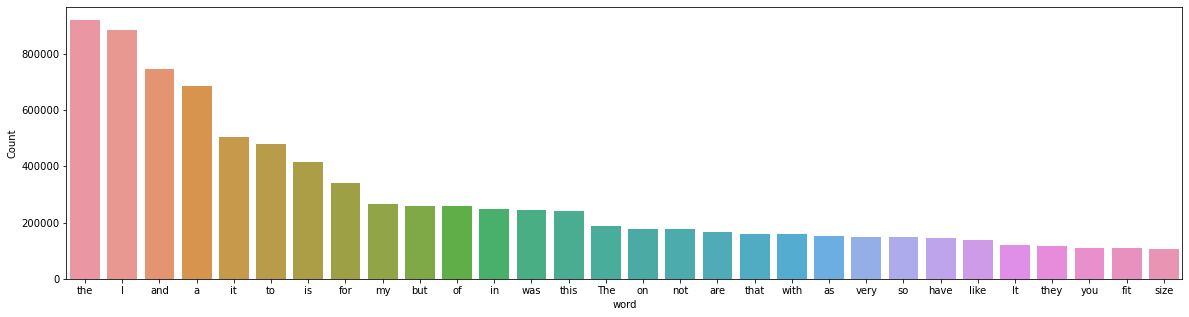

In [10]:
freq_words(review['reviewText'])

Obviously, 'the', 'I', 'and', 'it' are most common

In [11]:
df = review['reviewText'].to_frame()
#df[['reviewText']]
df.head()

,reviewText
0,Exactly what I needed.
1,"I agree with the other review, the opening is too small. I almost bent the hook on some very expensive earrings trying to get these up higher than just the end so they're not seen. Would not buy..."
2,Love these... I am going to order another pack to keep in work; someone (including myself) is always losing the back to an earring. I don't understand why all fish hook earrings don't have them. ...
3,too tiny an opening
4,Okay


In [12]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet as wn
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer 
ps = PorterStemmer()

#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('omw-1.4')

### Normalizing data 
Removing special characters, punctuation and numbers, and applying lowercase to all words.

In [13]:
df['text_clean'] = df['reviewText'].str.lower()
df['text_clean'] = df['text_clean'].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
df['text_clean'] = df['text_clean'].apply(lambda elem: re.sub(r"\d+", "", elem))

### Removing stop words

We chose to remove 'not' from our stopwords set as this may impact the meaning of negative reviews

Example: I did not like --> I did like

In [14]:
stop = set(stopwords.words('english'))
stop.remove('not')
##choose to remove not since it may impact the sentiment and bigram analysis

In [15]:
df['noStopword'] = df['text_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [16]:
df.head()

,reviewText,text_clean,noStopword
0,Exactly what I needed.,exactly what i needed,exactly needed
1,"I agree with the other review, the opening is too small. I almost bent the hook on some very expensive earrings trying to get these up higher than just the end so they're not seen. Would not buy...",i agree with the other review the opening is too small i almost bent the hook on some very expensive earrings trying to get these up higher than just the end so theyre not seen would not buy aga...,agree review opening small almost bent hook expensive earrings trying get higher end theyre not seen would not buy price not sending back
2,Love these... I am going to order another pack to keep in work; someone (including myself) is always losing the back to an earring. I don't understand why all fish hook earrings don't have them. ...,love these i am going to order another pack to keep in work someone including myself is always losing the back to an earring i dont understand why all fish hook earrings dont have them just wish...,love going order another pack keep work someone including always losing back earring dont understand fish hook earrings dont wish tiny bit longer
3,too tiny an opening,too tiny an opening,tiny opening
4,Okay,okay,okay


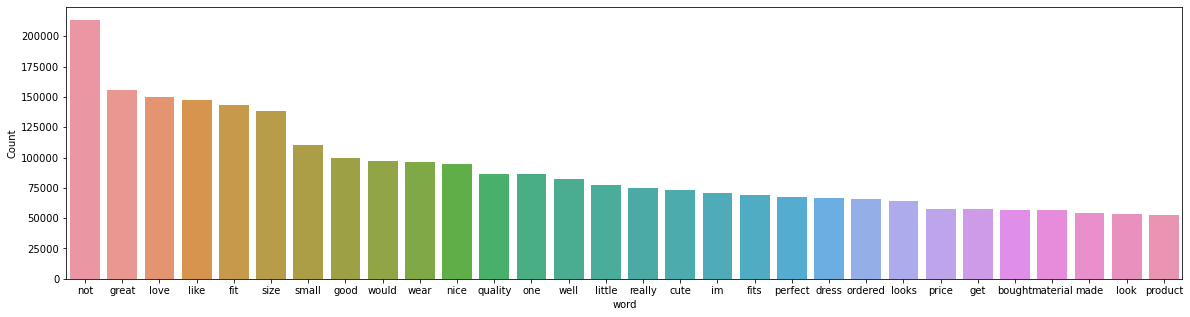

In [17]:
freq_words(df['noStopword'])

## Tokenization

Splitting our cleaned text into constituent parts by breaking apart unstructured data and natural language text into chunks for analysis as individual elements. 

In [18]:
df['token'] = df['noStopword'].apply(lambda x: word_tokenize(x))

In [19]:
df.head()

,reviewText,text_clean,noStopword,token
0,Exactly what I needed.,exactly what i needed,exactly needed,"[exactly, needed]"
1,"I agree with the other review, the opening is too small. I almost bent the hook on some very expensive earrings trying to get these up higher than just the end so they're not seen. Would not buy...",i agree with the other review the opening is too small i almost bent the hook on some very expensive earrings trying to get these up higher than just the end so theyre not seen would not buy aga...,agree review opening small almost bent hook expensive earrings trying get higher end theyre not seen would not buy price not sending back,"[agree, review, opening, small, almost, bent, hook, expensive, earrings, trying, get, higher, end, theyre, not, seen, would, not, buy, price, not, sending, back]"
2,Love these... I am going to order another pack to keep in work; someone (including myself) is always losing the back to an earring. I don't understand why all fish hook earrings don't have them. ...,love these i am going to order another pack to keep in work someone including myself is always losing the back to an earring i dont understand why all fish hook earrings dont have them just wish...,love going order another pack keep work someone including always losing back earring dont understand fish hook earrings dont wish tiny bit longer,"[love, going, order, another, pack, keep, work, someone, including, always, losing, back, earring, dont, understand, fish, hook, earrings, dont, wish, tiny, bit, longer]"
3,too tiny an opening,too tiny an opening,tiny opening,"[tiny, opening]"
4,Okay,okay,okay,[okay]


## Lemmatization

Process of reducing words to root form. This will reduce noise and the dimensionality of the final cleaned data for analysis. 

In [20]:
def word_lemmatizer(text):
    lem_text = [WordNetLemmatizer().lemmatize(i) for i in text]
    return lem_text

df['token_lemma'] = df['token'].apply(lambda x: word_lemmatizer(x))

In [21]:
df['clean'] = df['token_lemma'].str.join(' ')

In [22]:
df.head()

,reviewText,text_clean,noStopword,token,token_lemma,clean
0,Exactly what I needed.,exactly what i needed,exactly needed,"[exactly, needed]","[exactly, needed]",exactly needed
1,"I agree with the other review, the opening is too small. I almost bent the hook on some very expensive earrings trying to get these up higher than just the end so they're not seen. Would not buy...",i agree with the other review the opening is too small i almost bent the hook on some very expensive earrings trying to get these up higher than just the end so theyre not seen would not buy aga...,agree review opening small almost bent hook expensive earrings trying get higher end theyre not seen would not buy price not sending back,"[agree, review, opening, small, almost, bent, hook, expensive, earrings, trying, get, higher, end, theyre, not, seen, would, not, buy, price, not, sending, back]","[agree, review, opening, small, almost, bent, hook, expensive, earring, trying, get, higher, end, theyre, not, seen, would, not, buy, price, not, sending, back]",agree review opening small almost bent hook expensive earring trying get higher end theyre not seen would not buy price not sending back
2,Love these... I am going to order another pack to keep in work; someone (including myself) is always losing the back to an earring. I don't understand why all fish hook earrings don't have them. ...,love these i am going to order another pack to keep in work someone including myself is always losing the back to an earring i dont understand why all fish hook earrings dont have them just wish...,love going order another pack keep work someone including always losing back earring dont understand fish hook earrings dont wish tiny bit longer,"[love, going, order, another, pack, keep, work, someone, including, always, losing, back, earring, dont, understand, fish, hook, earrings, dont, wish, tiny, bit, longer]","[love, going, order, another, pack, keep, work, someone, including, always, losing, back, earring, dont, understand, fish, hook, earring, dont, wish, tiny, bit, longer]",love going order another pack keep work someone including always losing back earring dont understand fish hook earring dont wish tiny bit longer
3,too tiny an opening,too tiny an opening,tiny opening,"[tiny, opening]","[tiny, opening]",tiny opening
4,Okay,okay,okay,[okay],[okay],okay


## POS tagging and chunking

Categorising words to extract meaningful phrases from text (verbs, adverbs, adjectives, nouns, etc).

In [23]:
def word_pos_tagger(text):
    pos_tagged_text = nltk.pos_tag(text)
    return pos_tagged_text

nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/christinegao/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [24]:
df['token_pos'] = df['token'].apply(lambda x: word_pos_tagger(x))

In [25]:
df['nouns'] = df['token_pos'].apply(lambda x: [word for word, tag in x if tag in ['NN', 'NNS', 'NNP', 'NNPS']])
df['verbs'] = df['token_pos'].apply(lambda x: [word for word, tag in x if tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']])
df['adjs'] = df['token_pos'].apply(lambda x: [word for word, tag in x if tag.startswith("J")])
df['adverbs'] = df['token_pos'].apply(lambda x: [word for word, tag in x if tag.startswith("RB")])

In [26]:
df['token_Count'] = df['token'].str.len()

In [27]:
#df.head()

## EDA

In [28]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

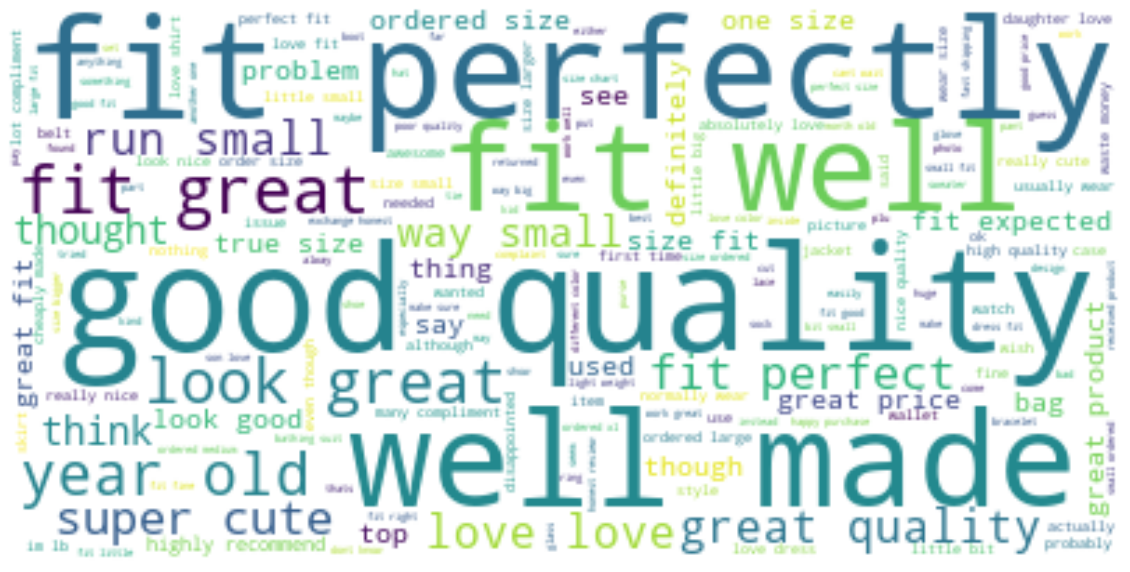

In [29]:
text = " ".join(i for i in df['clean'])
wordcloud = WordCloud(background_color="white").generate(text)
plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Feature Extraction

In [30]:
from nltk.collocations import *
from nltk.util import ngrams

In [31]:
word_list = ' '.join([i for i in df['clean']]).split()

In [32]:
(pd.Series(nltk.ngrams(word_list, 2)).value_counts())[:20]

(look, like)        20182
(good, quality)     18743
(fit, perfectly)    17742
(well, made)        16068
(fit, well)         15990
(fit, great)        15290
(look, great)       13214
(year, old)         12799
(like, picture)     12320
(fit, perfect)      11126
(super, cute)       10504
(love, love)        10122
(great, quality)    10096
(run, small)         9762
(way, small)         9141
(really, like)       8658
(fit, like)          8613
(fit, expected)      7968
(look, good)         7843
(great, price)       7774
dtype: int64

In [33]:
(pd.Series(nltk.ngrams(word_list, 3)).value_counts())[:20]

(look, like, picture)             4232
(love, love, love)                3073
(nothing, like, picture)          2312
(honest, unbiased, review)        2228
(would, not, recommend)           2185
(exchange, honest, review)        1947
(exchange, honest, unbiased)      1842
(would, definitely, recommend)    1802
(fit, true, size)                 1794
(discount, exchange, honest)      1790
(look, nothing, like)             1777
(im, not, sure)                   1756
(cant, wait, wear)                1731
(look, exactly, like)             1640
(exactly, like, picture)          1614
(one, size, fit)                  1603
(year, old, daughter)             1542
(received, many, compliment)      1481
(not, look, like)                 1448
(dont, waste, money)              1439
dtype: int64

In [34]:
search_word = ["love", "like", "hate", "great", "nice"] #'recommend']

no_opinion = ' '.join((filter(lambda val: val not in search_word, list(word_list)))).split()

In [35]:
(pd.Series(nltk.ngrams(no_opinion, 2)).value_counts())[:20]

(good, quality)        18848
(fit, perfectly)       17747
(fit, well)            16077
(well, made)           16069
(year, old)            12801
(fit, perfect)         11299
(super, cute)          10506
(run, small)            9768
(way, small)            9142
(look, good)            8207
(fit, expected)         8126
(ordered, size)         7781
(true, size)            7654
(size, fit)             7570
(would, not)            7288
(would, recommend)      7214
(one, size)             6412
(perfect, fit)          6245
(im, not)               6139
(highly, recommend)     6135
dtype: int64

In [36]:
(pd.Series(nltk.ngrams(no_opinion, 3)).value_counts())[:20]

(honest, unbiased, review)        2228
(would, not, recommend)           2185
(exchange, honest, review)        1947
(fit, true, size)                 1854
(exchange, honest, unbiased)      1842
(would, definitely, recommend)    1803
(discount, exchange, honest)      1790
(im, not, sure)                   1756
(cant, wait, wear)                1732
(one, size, fit)                  1614
(year, old, daughter)             1547
(received, many, compliment)      1491
(dont, waste, money)              1442
(fit, year, old)                  1428
(received, product, discount)     1419
(get, lot, compliment)            1397
(run, little, small)              1350
(got, lot, compliment)            1307
(would, highly, recommend)        1237
(not, true, size)                 1223
dtype: int64

## Sentiment Analysis

In [37]:
review['overall'].value_counts()
df['rating'] = review['overall']

In [38]:
def label_func(rating):
    if rating <= 2:
        return 'negative'
    if rating >= 4:
        return 'positive'
    else:
        return 'neutral'

df['sentiment'] = df['rating'].apply(label_func)

In [39]:
positive_review = df[(df["sentiment"] == 'positive')]['clean'].to_frame()
neutral_review = df[(df["sentiment"] == 'neutral')]['clean'].to_frame()
negative_review = df[(df["sentiment"] == 'negative')]['clean'].to_frame()

In [40]:
pos_clean = ' '.join([i for i in positive_review['clean']]).split()
neutral_clean = ' '.join([i for i in neutral_review['clean']]).split()
neg_clean = ' '.join([i for i in negative_review['clean']]).split()

In [41]:
pos_clean = ' '.join((filter(lambda val: val not in search_word, list(pos_clean)))).split()
neutral_clean = ' '.join((filter(lambda val: val not in search_word, list(neutral_clean)))).split()
neg_clean = ' '.join((filter(lambda val: val not in search_word, list(neg_clean)))).split()

In [42]:
n_gram_pos = (pd.Series(nltk.ngrams(pos_clean, 3)).value_counts()).to_frame()
n_gram_pos['sentiment'] = 'positive'

In [43]:
n_gram_neg = (pd.Series(nltk.ngrams(neg_clean, 3)).value_counts()).to_frame()
n_gram_neg['sentiment'] = 'negative'

n_gram_sent = pd.concat([n_gram_pos[:10], n_gram_neg[:10]])

In [44]:
n_gram_sent = n_gram_sent.rename({0: 'frequency'}, axis='columns')
n_gram_sent = n_gram_sent.sort_values(by=['frequency'], ascending=False)
n_gram_sent = n_gram_sent.reset_index()
n_gram_sent = n_gram_sent.rename({'index': 'words'}, axis='columns')

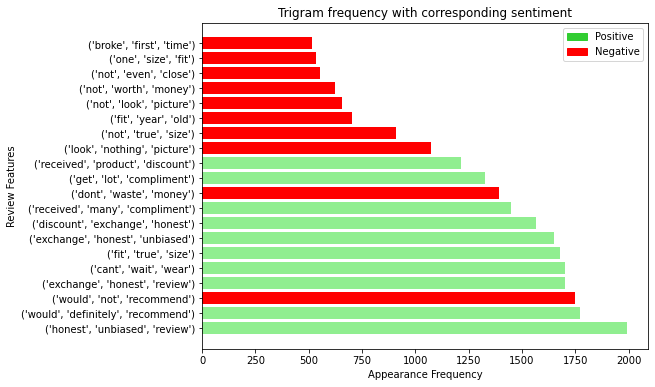

In [45]:
top_n = n_gram_sent[:25]
#top_n.info()
clrs = ['lightgreen' if (x == 'positive') else 'red' for x in top_n['sentiment']]
import matplotlib.patches as mpatches


plt.figure(figsize=(8, 6))
plt.barh([str(i) for i in top_n['words']], top_n['frequency'], color=clrs)
plt.title('Trigram frequency with corresponding sentiment')
plt.xlabel('Appearance Frequency')
plt.ylabel('Review Features')
red_patch = mpatches.Patch(color='limegreen', label='Positive')
green_path = mpatches.Patch(color='red', label='Negative')
plt.legend(handles=[red_patch, green_path])
plt.show()


In [46]:
text_corpus_positive_review = ' '.join(pos_clean)
text_corpus_neutral_review = ' '.join(neutral_clean)
text_corpus_negative_review = ' '.join(neg_clean)

In [47]:
def most_common_word_func(text, n_words=25):
    words = word_tokenize(text)
    fdist = FreqDist(words) 
    
    n_words = n_words
    df_fdist = pd.DataFrame({'Word': fdist.keys(),'Frequency': fdist.values()})
    df_fdist = df_fdist.sort_values(by='Frequency', ascending=False).head(n_words)
    
    return df_fdist

In [48]:
df_most_common_words_text_corpus_positive_review = most_common_word_func(text_corpus_positive_review)
df_most_common_words_text_corpus_neutral_review = most_common_word_func(text_corpus_neutral_review)
df_most_common_words_text_corpus_negative_review = most_common_word_func(text_corpus_negative_review)

In [49]:
splited_data = [df_most_common_words_text_corpus_positive_review,
                df_most_common_words_text_corpus_neutral_review,
                df_most_common_words_text_corpus_negative_review]

color_list = ['green', 'gray', 'red']
title_list = ['Positive Review', 'Neutral Review', 'Negative Review']

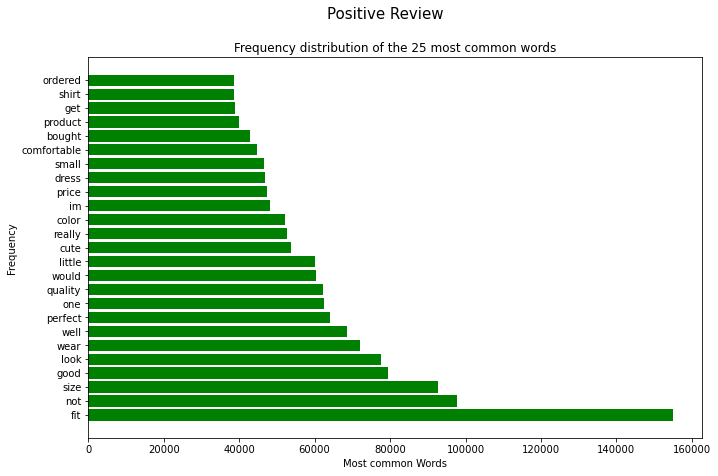

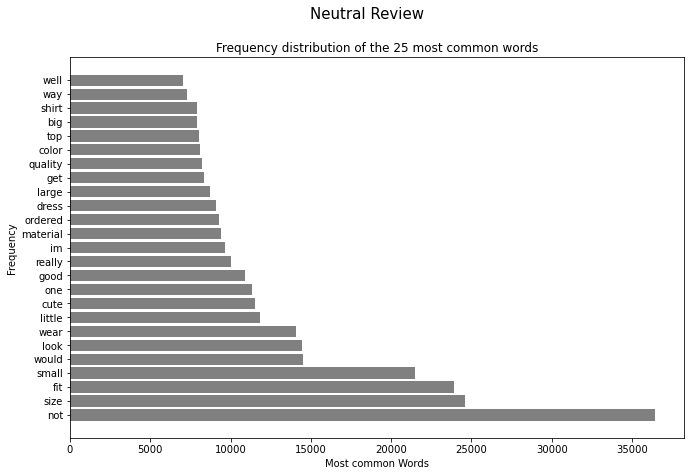

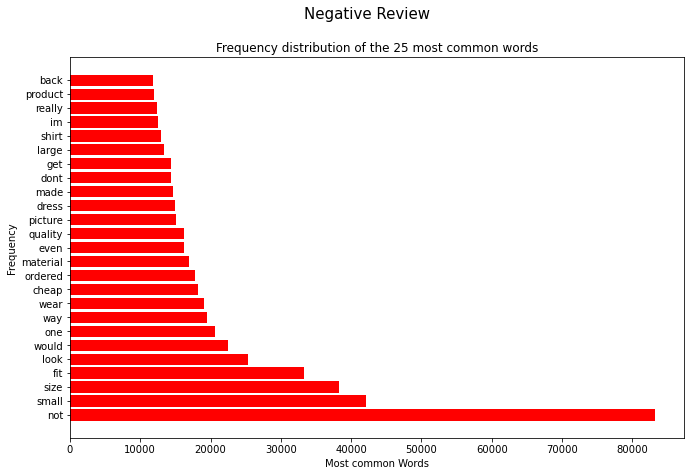

In [50]:
for item in range(3):
    plt.figure(figsize=(11,7))
    plt.barh(splited_data[item]['Word'], 
            splited_data[item]['Frequency'],
            color=color_list[item])
    plt.xlabel('Most common Words')
    plt.ylabel("Frequency")
    plt.title("Frequency distribution of the 25 most common words")
    plt.suptitle(title_list[item], fontsize=15)
    plt.show()

## Topic Modeling

Topic modeling is a method similar to clustering on numeric data (instead used on text documents) which finds natural groups of items, or phrases that tend to co-occur most frequently.

In [51]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

dictionary = corpora.Dictionary(df['token_lemma'])

In [52]:
doc_term_matrix = [dictionary.doc2bow(word) for word in df['token_lemma']]

The LDA algorithm is guided by 2 principles:

1. Every document is a mixture of topics, and each document may contain words in particular proportions.
2. Every topic is a mixture of words

LDA is a mathematical method to estimate these principes at the same time (https://www.tidytextmining.com/topicmodeling.html)

In [53]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=7, random_state=100,
                chunksize=1000, passes=2)

In [129]:
lda_model.print_topics()

[(0,
  '0.079*"size" + 0.059*"small" + 0.043*"fit" + 0.032*"ordered" + 0.025*"large" + 0.022*"not" + 0.018*"wear" + 0.017*"way" + 0.016*"big" + 0.016*"would"'),
 (1,
  '0.049*"shoe" + 0.037*"pair" + 0.022*"awesome" + 0.022*"sock" + 0.020*"watch" + 0.020*"chart" + 0.019*"foot" + 0.015*"returning" + 0.015*"company" + 0.015*"brand"'),
 (2,
  '0.040*"not" + 0.022*"like" + 0.013*"would" + 0.012*"look" + 0.012*"review" + 0.012*"one" + 0.010*"dont" + 0.009*"back" + 0.009*"product" + 0.008*"get"'),
 (3,
  '0.051*"dress" + 0.042*"cute" + 0.033*"fit" + 0.022*"love" + 0.021*"comfortable" + 0.020*"material" + 0.020*"wear" + 0.017*"super" + 0.016*"well" + 0.016*"soft"'),
 (4,
  '0.056*"great" + 0.054*"quality" + 0.044*"good" + 0.036*"fit" + 0.033*"nice" + 0.029*"color" + 0.028*"price" + 0.027*"love" + 0.026*"look" + 0.023*"shirt"'),
 (5,
  '0.042*"beautiful" + 0.025*"compliment" + 0.020*"wear" + 0.019*"many" + 0.017*"get" + 0.016*"lot" + 0.016*"best" + 0.015*"got" + 0.014*"time" + 0.014*"pretty"'),

In [122]:
lda_viz = gensimvis.prepare(lda_model, doc_term_matrix, dictionary)

/Users/christinegao/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/christinegao/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/christinegao/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/christinegao/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/christ

/Users/christinegao/opt/anaconda3/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/christinegao/opt/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/christinegao/opt/anaconda3/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/christinegao/opt/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/christinegao/opt/anaconda3/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: di

In [123]:
pyLDAvis.display(lda_viz)

In [54]:
from textblob import TextBlob

df = df[df.token_Count>2] # Whole Dataset

def norm_lemm_v_a_func_token(text):
    '''
    Lemmatize tokens
    
    Step 1: Use WordNetLemmatizer() with POS tag 'v' to lemmatize the created tokens     
    Step 2: Use WordNetLemmatizer() with POS tag 'a' to lemmatize the created tokens
    
    Args:
        text (str): String to which the functions are to be applied, string
    
    Returns:
        String with lemmatized words
    '''

    text1 = [WordNetLemmatizer().lemmatize(word, pos='v') for word in text]
    text2 = [WordNetLemmatizer().lemmatize(word, pos='a') for word in text1]
    return text2

# Filter out nouns (product-related features), verbs and subjective adverbs 
# & adjs which reflect strong customer opinions.
word_len_threshold = 2
df['tagged_filtered'] = df['token_pos'].apply(lambda x: [word for word, tag in x 
                                                    if len(word) > word_len_threshold and
                                                        (   tag.startswith("N") 
                                                        or tag.startswith("V")
                                                        or (tag.startswith("RB") and TextBlob(word).sentiment.subjectivity>0)
                                                        or (tag.startswith("J") and TextBlob(word).sentiment.subjectivity>0)  )])

df["tokenized_filtered"] = df['tagged_filtered'].apply(norm_lemm_v_a_func_token)

df

,reviewText,text_clean,noStopword,token,token_lemma,clean,token_pos,nouns,verbs,adjs,adverbs,token_Count,rating,sentiment,tagged_filtered,tokenized_filtered
1,"I agree with the other review, the opening is too small. I almost bent the hook on some very expensive earrings trying to get these up higher than just the end so they're not seen. Would not buy...",i agree with the other review the opening is too small i almost bent the hook on some very expensive earrings trying to get these up higher than just the end so theyre not seen would not buy aga...,agree review opening small almost bent hook expensive earrings trying get higher end theyre not seen would not buy price not sending back,"[agree, review, opening, small, almost, bent, hook, expensive, earrings, trying, get, higher, end, theyre, not, seen, would, not, buy, price, not, sending, back]","[agree, review, opening, small, almost, bent, hook, expensive, earring, trying, get, higher, end, theyre, not, seen, would, not, buy, price, not, sending, back]",agree review opening small almost bent hook expensive earring trying get higher end theyre not seen would not buy price not sending back,"[(agree, JJ), (review, NN), (opening, VBG), (small, JJ), (almost, RB), (bent, JJ), (hook, NN), (expensive, JJ), (earrings, NNS), (trying, VBG), (get, VB), (higher, JJR), (end, NN), (theyre, NN), (...","[review, hook, earrings, end, theyre, price]","[opening, trying, get, seen, buy, sending]","[agree, small, bent, expensive, higher]","[almost, not, not, not]",23,2,negative,"[review, opening, small, hook, expensive, earrings, trying, get, higher, end, theyre, seen, buy, price, sending]","[review, open, small, hook, expensive, earrings, try, get, high, end, theyre, see, buy, price, send]"
2,Love these... I am going to order another pack to keep in work; someone (including myself) is always losing the back to an earring. I don't understand why all fish hook earrings don't have them. ...,love these i am going to order another pack to keep in work someone including myself is always losing the back to an earring i dont understand why all fish hook earrings dont have them just wish...,love going order another pack keep work someone including always losing back earring dont understand fish hook earrings dont wish tiny bit longer,"[love, going, order, another, pack, keep, work, someone, including, always, losing, back, earring, dont, understand, fish, hook, earrings, dont, wish, tiny, bit, longer]","[love, going, order, another, pack, keep, work, someone, including, always, losing, back, earring, dont, understand, fish, hook, earring, dont, wish, tiny, bit, longer]",love going order another pack keep work someone including always losing back earring dont understand fish hook earring dont wish tiny bit longer,"[(love, VB), (going, VBG), (order, NN), (another, DT), (pack, NN), (keep, NN), (work, NN), (someone, NN), (including, VBG), (always, RB), (losing, VBG), (back, RP), (earring, VBG), (dont, NN), (un...","[order, pack, keep, work, someone, dont, fish, hook, earrings, bit]","[love, going, including, losing, earring, dont]","[understand, wish, tiny]","[always, longer]",23,4,positive,"[love, going, order, pack, keep, work, someone, including, losing, earring, dont, fish, hook, earrings, dont, tiny, bit]","[love, go, order, pack, keep, work, someone, include, lose, earring, dont, fish, hook, earrings, dont, tiny, bite]"
6,"These little plastic backs work great. No more loosing ""hook"" earrings! Wish I had ordered these sooner before I had lost some of my favorite earrings!",these little plastic backs work great no more loosing hook earrings wish i had ordered these sooner before i had lost some of my favorite earrings,little plastic backs work great loosing hook earrings wish ordered sooner lost favorite earrings,"[little, plastic, backs, work, great, loosing, hook, earrings, wish, ordered, sooner, lost, favorite, earrings]","[little, plastic, back, work, great, loosing, hook, earring, wish, ordered,

In [55]:
def ngram(text):
    """
    Transform the review text into all bigram and trigram combinations.
    
    Input: String of text.
    
    Output: A list of all bigram and trigram combinations of the input text. Each combination is a string.
    
    """
    return [" ".join(phrase) for phrase in list(nltk.ngrams(text.split(), 2))] + 
        [" ".join(phrase) for phrase in list(nltk.ngrams(text.split(), 3))]

df["bigram"] = df["clean"].apply(ngram)

In [56]:
# Divide dictonary into three sentiment states to understand the main user opinions in each of them.
df_pos = df[df.sentiment=="positive"]
df_neu = df[df.sentiment=="neutral"]
df_neg = df[df.sentiment=="negative"]

pos_dictionary = corpora.Dictionary(df_pos['tokenized_filtered'])
neu_dictionary = corpora.Dictionary(df_neu['tokenized_filtered'])
neg_dictionary = corpora.Dictionary(df_neg['tokenized_filtered'])

# Filter out tokens appear in 1) less than 1% of all reviews. (less representative) (no ) 2) more than 80% of all reviews (no benefit for topic distinguishing).
pos_dictionary.filter_extremes(no_below=0.01*len(pos_dictionary.token2id), no_above=0.8) 
neu_dictionary.filter_extremes(no_below=0.01*len(neu_dictionary.token2id), no_above=0.8) 
neg_dictionary.filter_extremes(no_below=0.01*len(neg_dictionary.token2id), no_above=0.8)

pos_doc_term_matrix = [pos_dictionary.doc2bow(word) for word in df_pos['tokenized_filtered']]
neu_doc_term_matrix = [neu_dictionary.doc2bow(word) for word in df_neu['tokenized_filtered']]
neg_doc_term_matrix = [neg_dictionary.doc2bow(word) for word in df_neg['tokenized_filtered']]

In [57]:
# LDA model parameter tuning

LDA = gensim.models.ldamodel.LdaModel

pos_lda_model = LDA(corpus=pos_doc_term_matrix, id2word=pos_dictionary, num_topics=10, random_state=100, chunksize=100, passes=10)
neu_lda_model = LDA(corpus=neu_doc_term_matrix, id2word=neu_dictionary, num_topics=10, random_state=100, chunksize=100, passes=10)
neg_lda_model = LDA(corpus=neg_doc_term_matrix, id2word=neg_dictionary, num_topics=10, random_state=100, chunksize=100, passes=10)

The pyLDAvis package allows us to visualize topic relationships.

The circles represent each topic. The distance between the circles visualizes topic relatedness. These are mapped through dimensionality reduction (PCA/t-sne) on distances between each topic’s probability distributions into 2D space. This shows whether our model developed distinct topics. We want to tune model parameters and number of topics to minimize circle overlap.

The right panel in the pyLDAvis interface shows the top words associated with the specific topic selected in the left panel, along with bar graphs for their weight. The blue bar for any word represents that word’s frequency in the overall topic model. The red bar represents that word’s frequency within the specific topic you have selected.

In [130]:
# Topics in positive reviews.

pos_lda_model.print_topics(num_topics=10, num_words=5)

[(0,
  '0.193*"size" + 0.119*"order" + 0.103*"fit" + 0.078*"large" + 0.066*"expect"'),
 (1,
  '0.105*"big" + 0.082*"pretty" + 0.079*"little" + 0.069*"perfectly" + 0.065*"honest"'),
 (2,
  '0.083*"comfortable" + 0.052*"right" + 0.040*"design" + 0.040*"fabric" + 0.037*"want"'),
 (3,
  '0.160*"love" + 0.096*"dress" + 0.078*"perfect" + 0.077*"fit" + 0.056*"great"'),
 (4,
  '0.040*"top" + 0.037*"get" + 0.030*"wear" + 0.022*"use" + 0.022*"discount"'),
 (5,
  '0.090*"wear" + 0.073*"beautiful" + 0.054*"long" + 0.044*"time" + 0.043*"definitely"'),
 (6,
  '0.123*"great" + 0.097*"product" + 0.063*"price" + 0.051*"quality" + 0.049*"love"'),
 (7,
  '0.150*"good" + 0.096*"nice" + 0.091*"shirt" + 0.085*"look" + 0.066*"quality"'),
 (8,
  '0.078*"color" + 0.058*"love" + 0.056*"soft" + 0.031*"comfortable" + 0.031*"great"'),
 (9,
  '0.084*"cute" + 0.059*"review" + 0.052*"small" + 0.039*"receive" + 0.036*"super"')]

The positive reviews mainly centered around the following topics:
​
1. Product Quality:

    (1) Material: "soft", "top"
    
    (2) Size: "fit"
    
    (3) Appearance: "cute", "look as expected", "color"
    
2. Product Price
    
    (1) "discount"
    
    (2) "worth the price"
    
Especially, many adverbs and adjs are used to express their strong satisfaction (different from neu/neg reviews): top, very, great, love, super, really.
   
This reveals that customers cares about product quality and prices, with material, size, style, discount as top deciding fatcors. They would describe good products as "look as expected from pictures".

In [98]:
# Topics in neutral reviews.

neu_lda_model.print_topics(num_topics=10, num_words=5)

[(0,
  '0.102*"pretty" + 0.082*"fabric" + 0.072*"see" + 0.046*"bad" + 0.036*"kind"'),
 (1,
  '0.041*"time" + 0.034*"come" + 0.033*"love" + 0.033*"make" + 0.030*"wear"'),
 (2,
  '0.096*"tight" + 0.080*"give" + 0.042*"area" + 0.042*"wear" + 0.037*"enough"'),
 (3,
  '0.205*"top" + 0.076*"keep" + 0.066*"work" + 0.061*"fine" + 0.056*"side"'),
 (4,
  '0.185*"nice" + 0.100*"bite" + 0.099*"make" + 0.083*"really" + 0.047*"look"'),
 (5, '0.048*"say" + 0.038*"sure" + 0.035*"use" + 0.035*"know" + 0.033*"old"'),
 (6,
  '0.182*"size" + 0.163*"small" + 0.097*"order" + 0.079*"large" + 0.064*"fit"'),
 (7,
  '0.066*"dress" + 0.046*"way" + 0.040*"fit" + 0.035*"return" + 0.032*"cute"'),
 (8,
  '0.090*"shirt" + 0.072*"cute" + 0.063*"good" + 0.054*"material" + 0.054*"fit"'),
 (9,
  '0.073*"color" + 0.073*"look" + 0.058*"picture" + 0.037*"cheap" + 0.033*"good"')]

The neutral reviews mainly centered around the following topics:

1. Family:
    (1) "daugher"
2. Product Size (controversial)
    (1) Some customers stated "fit"
    (2) Some stated that size might not be just right: "large" & "small", "short", "little"
    (3) "return": Some products might be returned
3. Product Look
    (1) "nice", "cute", "like picture"
   
Compared with positive reviews, neutral reviews became more controversial in consumer opinions, especially in product size. Many customers might be satisfied with the product quality and look, but just the size didn't fit. So they would give a neutral star.

In [99]:
# Topics in negative reviews.

neg_lda_model.print_topics(num_topics=10, num_words=5)

[(0,
  '0.171*"size" + 0.171*"small" + 0.078*"order" + 0.074*"fit" + 0.062*"way"'),
 (1,
  '0.162*"look" + 0.086*"picture" + 0.044*"really" + 0.031*"good" + 0.030*"show"'),
 (2,
  '0.114*"give" + 0.068*"nothing" + 0.066*"star" + 0.046*"worth" + 0.038*"price"'),
 (3,
  '0.092*"top" + 0.071*"color" + 0.033*"think" + 0.030*"dont" + 0.029*"get"'),
 (4,
  '0.103*"dress" + 0.092*"material" + 0.086*"cheap" + 0.065*"make" + 0.043*"thin"'),
 (5,
  '0.129*"shirt" + 0.049*"fit" + 0.047*"love" + 0.043*"tight" + 0.038*"nice"'),
 (6,
  '0.066*"wear" + 0.066*"time" + 0.058*"break" + 0.043*"get" + 0.043*"first"'),
 (7,
  '0.093*"quality" + 0.066*"product" + 0.065*"cute" + 0.050*"return" + 0.049*"purchase"'),
 (8,
  '0.037*"work" + 0.035*"fit" + 0.034*"didnt" + 0.030*"make" + 0.029*"old"'),
 (9,
  '0.158*"come" + 0.127*"short" + 0.063*"say" + 0.041*"loose" + 0.030*"skirt"')]

The negative reviews mainly centered around the following topics:

1. Product Size (controversial)
    (1) Some customers stated "fit" (but might be not fit and the not was not captured by topic modeling)
    (2) Some stated that size might not be just right: "large" & "small", "short", "little"
    (3) "return": Some products might be returned
2. Product Price
    (1) "cheap"
   
Compared with pos/neu reviews, negative reviews are still controversial in consumer opinions, especially in product size. Also, the product might be cheap or look cheap, which did not match customers' expectations.

## LDA for bigrams and trigrams

In [61]:
# Aggregate review tokens into bi-grams and tri-grams to better understand structured user opinions instead of scattered words.
def ngram(text):
    """
    Transform the review text into all bigram and trigram combinations.
    
    Input: String of text.
    
    Output: A list of all bigram and trigram combinations of the input text. Each combination is a string.
    
    """
    return [" ".join(phrase) for phrase in list(nltk.ngrams(text.split(), 2))] + [" ".join(phrase) for phrase in list(nltk.ngrams(text.split(), 3))]


df["bigram"] = df["clean"].apply(ngram)

# Divide dictonary into three sentiment states to understand the main user opinions in each of them.
df_pos_ng = df[df.sentiment=="positive"]
df_neu_ng = df[df.sentiment=="neutral"]
df_neg_ng = df[df.sentiment=="negative"]

ng_pos_dictionary = corpora.Dictionary(df_pos_ng['bigram'])
ng_neu_dictionary = corpora.Dictionary(df_neu_ng['bigram'])
ng_neg_dictionary = corpora.Dictionary(df_neg_ng['bigram'])

# Filter out tokens appear in 1) less than 3 reviews. (less representative) (no ) 2) more than 80% of all reviews (no benefit for topic distinguishing).
ng_pos_dictionary.filter_extremes(no_below=3, no_above=0.8) 
ng_neu_dictionary.filter_extremes(no_below=3, no_above=0.8) 
ng_neg_dictionary.filter_extremes(no_below=3, no_above=0.8)

ng_pos_doc_term_matrix = [ng_pos_dictionary.doc2bow(word) for word in df_pos_ng['bigram']]
ng_neu_doc_term_matrix = [ng_neu_dictionary.doc2bow(word) for word in df_neu_ng['bigram']]
ng_neg_doc_term_matrix = [ng_neg_dictionary.doc2bow(word) for word in df_neg_ng['bigram']]

df

,reviewText,text_clean,noStopword,token,token_lemma,clean,token_pos,nouns,verbs,adjs,adverbs,token_Count,rating,sentiment,tagged_filtered,tokenized_filtered,bigram
1,"I agree with the other review, the opening is too small. I almost bent the hook on some very expensive earrings trying to get these up higher than just the end so they're not seen. Would not buy...",i agree with the other review the opening is too small i almost bent the hook on some very expensive earrings trying to get these up higher than just the end so theyre not seen would not buy aga...,agree review opening small almost bent hook expensive earrings trying get higher end theyre not seen would not buy price not sending back,"[agree, review, opening, small, almost, bent, hook, expensive, earrings, trying, get, higher, end, theyre, not, seen, would, not, buy, price, not, sending, back]","[agree, review, opening, small, almost, bent, hook, expensive, earring, trying, get, higher, end, theyre, not, seen, would, not, buy, price, not, sending, back]",agree review opening small almost bent hook expensive earring trying get higher end theyre not seen would not buy price not sending back,"[(agree, JJ), (review, NN), (opening, VBG), (small, JJ), (almost, RB), (bent, JJ), (hook, NN), (expensive, JJ), (earrings, NNS), (trying, VBG), (get, VB), (higher, JJR), (end, NN), (theyre, NN), (...","[review, hook, earrings, end, theyre, price]","[opening, trying, get, seen, buy, sending]","[agree, small, bent, expensive, higher]","[almost, not, not, not]",23,2,negative,"[review, opening, small, hook, expensive, earrings, trying, get, higher, end, theyre, seen, buy, price, sending]","[review, open, small, hook, expensive, earrings, try, get, high, end, theyre, see, buy, price, send]","[agree review, review opening, opening small, small almost, almost bent, bent hook, hook expensive, expensive earring, earring trying, trying get, get higher, higher end, end theyre, theyre not, n..."
2,Love these... I am going to order another pack to keep in work; someone (including myself) is always losing the back to an earring. I don't understand why all fish hook earrings don't have them. ...,love these i am going to order another pack to keep in work someone including myself is always losing the back to an earring i dont understand why all fish hook earrings dont have them just wish...,love going order another pack keep work someone including always losing back earring dont understand fish hook earrings dont wish tiny bit longer,"[love, going, order, another, pack, keep, work, someone, including, always, losing, back, earring, dont, understand, fish, hook, earrings, dont, wish, tiny, bit, longer]","[love, going, order, another, pack, keep, work, someone, including, always, losing, back, earring, dont, understand, fish, hook, earring, dont, wish, tiny, bit, longer]",love going order another pack keep work someone including always losing back earring dont understand fish hook earring dont wish tiny bit longer,"[(love, VB), (going, VBG), (order, NN), (another, DT), (pack, NN), (keep, NN), (work, NN), (someone, NN), (including, VBG), (always, RB), (losing, VBG), (back, RP), (earring, VBG), (dont, NN), (un...","[order, pack, keep, work, someone, dont, fish, hook, earrings, bit]","[love, going, including, losing, earring, dont]","[understand, wish, tiny]","[always, longer]",23,4,positive,"[love, going, order, pack, keep, work, someone, including, losing, earring, dont, fish, hook, earrings, dont, tiny, bit]","[love, go, order, pack, keep, work, someone, include, lose, earring, dont, fish, hook, earrings, dont, tiny, bite]","[love going, going order, order another, another pack, pack keep, keep work, work someone, someone including, including always, always losing, losing back, back earring, earring dont, dont underst..."
6,"These little plastic backs work great. No more loosing ""hook"" earrings! Wish I had ordered these sooner before I had lost some of my favorite earrings!",these little plastic ba

In [131]:
ng_pos_dictionary.token2id

{'another pack': 0,
 'back earring': 1,
 'bit longer': 2,
 'dont understand': 3,
 'earring dont': 4,
 'going order': 5,
 'going order another': 6,
 'love going': 7,
 'order another': 8,
 'tiny bit': 9,
 'back work': 10,
 'little plastic': 11,
 'wish ordered': 12,
 'work great': 13,
 'good quality': 14,
 'held well': 15,
 'long time': 16,
 'may able': 17,
 'product price': 18,
 'web site': 19,
 'love looking': 20,
 'happy purchase': 21,
 'product happy': 22,
 'quality product': 23,
 'big enough': 24,
 'come box': 25,
 'get little': 26,
 'not quite': 27,
 'quite big': 28,
 'still get': 29,
 'item purchased': 30,
 'last forever': 31,
 'made last': 32,
 'purchased several': 33,
 'dont want': 34,
 'inside purse': 35,
 'love think': 36,
 'bought different': 37,
 'different one': 38,
 'falling apart': 39,
 'last year': 40,
 'made well': 41,
 'one last': 42,
 'well hold': 43,
 'wont hold': 44,
 'zipper compartment': 45,
 'amazon one': 46,
 'ive ordered': 47,
 'durable look': 48,
 'look great':

In [63]:
# LDA model parameter tuning

LDA = gensim.models.ldamodel.LdaModel

ng_pos_lda_model = LDA(corpus=ng_pos_doc_term_matrix, id2word=ng_pos_dictionary, num_topics=8, random_state=100, chunksize=100, passes=2)
ng_neu_lda_model = LDA(corpus=ng_neu_doc_term_matrix, id2word=ng_neu_dictionary, num_topics=8, random_state=100, chunksize=100, passes=2)
ng_neg_lda_model = LDA(corpus=ng_neg_doc_term_matrix, id2word=ng_neg_dictionary, num_topics=8, random_state=100, chunksize=100, passes=2)

In [139]:
# Topics in positive reviews.

for topic in ng_pos_lda_model.print_topics(num_topics=8, num_words=6):
    print("Topic {}: {}".format(topic[0], topic[1]))

Topic 0: 0.028*"good quality" + 0.028*"well made" + 0.016*"really like" + 0.015*"true size" + 0.011*"would recommend" + 0.011*"love shirt"
Topic 1: 0.022*"fit well" + 0.013*"fit expected" + 0.008*"im lb" + 0.008*"size fit" + 0.007*"perfect fit" + 0.007*"lot compliment"
Topic 2: 0.016*"look great" + 0.015*"look like" + 0.010*"bathing suit" + 0.008*"like picture" + 0.008*"daughter love" + 0.007*"highly recommend"
Topic 3: 0.018*"great quality" + 0.014*"year old" + 0.009*"run small" + 0.008*"usually wear" + 0.008*"normally wear" + 0.008*"love fit"
Topic 4: 0.018*"fit perfect" + 0.016*"received product" + 0.016*"love love" + 0.015*"love dress" + 0.008*"little big" + 0.008*"great product"
Topic 5: 0.031*"fit great" + 0.024*"super cute" + 0.012*"absolutely love" + 0.011*"great price" + 0.011*"great fit" + 0.009*"different color"
Topic 6: 0.031*"fit perfectly" + 0.010*"ordered size" + 0.010*"really cute" + 0.008*"order size" + 0.007*"fit like" + 0.006*"ordered medium"
Topic 7: 0.016*"exchange

In [142]:
ng_pos_lda_model.print_topics(num_topics=8, num_words=5)

[(0,
  '0.028*"good quality" + 0.028*"well made" + 0.016*"really like" + 0.015*"true size" + 0.011*"would recommend"'),
 (1,
  '0.022*"fit well" + 0.013*"fit expected" + 0.008*"im lb" + 0.008*"size fit" + 0.007*"perfect fit"'),
 (2,
  '0.016*"look great" + 0.015*"look like" + 0.010*"bathing suit" + 0.008*"like picture" + 0.008*"daughter love"'),
 (3,
  '0.018*"great quality" + 0.014*"year old" + 0.009*"run small" + 0.008*"usually wear" + 0.008*"normally wear"'),
 (4,
  '0.018*"fit perfect" + 0.016*"received product" + 0.016*"love love" + 0.015*"love dress" + 0.008*"little big"'),
 (5,
  '0.031*"fit great" + 0.024*"super cute" + 0.012*"absolutely love" + 0.011*"great price" + 0.011*"great fit"'),
 (6,
  '0.031*"fit perfectly" + 0.010*"ordered size" + 0.010*"really cute" + 0.008*"order size" + 0.007*"fit like"'),
 (7,
  '0.016*"exchange honest" + 0.014*"honest review" + 0.013*"honest unbiased" + 0.011*"unbiased review" + 0.009*"honest unbiased review"')]

The positive reviews mainly centered around the following topics:

Pros:
1. Great quality
2. Size fit
3. Look good
4. Comfortable
5. Like Picture and Product Description
6. Discount

All compliments, very few complaints.
    
This is aligned with the word-level topic modeling on positive reviews.

In [65]:
# Topics in neutral reviews.

for topic in ng_neu_lda_model.print_topics(num_topics=8, num_words=6):
    print("Topic {}: {}".format(topic[0], topic[1]))

Topic 0: 0.034*"run small" + 0.016*"super cute" + 0.009*"way big" + 0.008*"top fit" + 0.007*"really like" + 0.006*"size ordered"
Topic 1: 0.017*"look like" + 0.016*"way small" + 0.015*"fit well" + 0.013*"really cute" + 0.011*"like picture" + 0.011*"size small"
Topic 2: 0.018*"fit like" + 0.011*"little small" + 0.011*"larger size" + 0.010*"two size" + 0.010*"received product" + 0.009*"bit small"
Topic 3: 0.013*"good quality" + 0.011*"not fit" + 0.010*"normally wear" + 0.010*"bathing suit" + 0.007*"cheaply made" + 0.007*"ordered medium"
Topic 4: 0.011*"ordered size" + 0.009*"year old" + 0.009*"well made" + 0.008*"order size" + 0.008*"one size" + 0.008*"im not"
Topic 5: 0.015*"would not" + 0.009*"dont think" + 0.009*"little tight" + 0.008*"fit ok" + 0.008*"doesnt fit" + 0.007*"dont know"
Topic 6: 0.013*"not sure" + 0.012*"usually wear" + 0.011*"cute dress" + 0.010*"ordered large" + 0.009*"wear size" + 0.009*"size chart"
Topic 7: 0.009*"honest review" + 0.008*"ordered xl" + 0.008*"exchange

In [143]:
ng_neu_lda_model.print_topics(num_topics=8, num_words=5)

[(0,
  '0.034*"run small" + 0.016*"super cute" + 0.009*"way big" + 0.008*"top fit" + 0.007*"really like"'),
 (1,
  '0.017*"look like" + 0.016*"way small" + 0.015*"fit well" + 0.013*"really cute" + 0.011*"like picture"'),
 (2,
  '0.018*"fit like" + 0.011*"little small" + 0.011*"larger size" + 0.010*"two size" + 0.010*"received product"'),
 (3,
  '0.013*"good quality" + 0.011*"not fit" + 0.010*"normally wear" + 0.010*"bathing suit" + 0.007*"cheaply made"'),
 (4,
  '0.011*"ordered size" + 0.009*"year old" + 0.009*"well made" + 0.008*"order size" + 0.008*"one size"'),
 (5,
  '0.015*"would not" + 0.009*"dont think" + 0.009*"little tight" + 0.008*"fit ok" + 0.008*"doesnt fit"'),
 (6,
  '0.013*"not sure" + 0.012*"usually wear" + 0.011*"cute dress" + 0.010*"ordered large" + 0.009*"wear size"'),
 (7,
  '0.009*"honest review" + 0.008*"ordered xl" + 0.008*"exchange honest" + 0.007*"get pay" + 0.007*"look good"')]

The neutral reviews mainly centered around the following topics:

Pros:
1. Great quality
2. Size fit (for some)
3. Look good

Cons:
1. Size might be too large or small. Not fitting well.

Compliments and complaints mixed together.
    
This is aligned with the word-level topic modeling on neutral reviews. The major complaints centered around size due to online shopping.

In [66]:
# Topics in negative reviews.

for topic in ng_neg_lda_model.print_topics(num_topics=8, num_words=6):
    print("Topic {}: {}".format(topic[0], topic[1]))

Topic 0: 0.023*"fit like" + 0.020*"nothing like" + 0.010*"small ordered" + 0.009*"look nothing" + 0.009*"look nothing like" + 0.009*"way big"
Topic 1: 0.019*"cheaply made" + 0.018*"not buy" + 0.016*"not worth" + 0.013*"not good" + 0.011*"poorly made" + 0.010*"not like"
Topic 2: 0.030*"look like" + 0.027*"way small" + 0.013*"not fit" + 0.013*"year old" + 0.012*"not even" + 0.011*"would not"
Topic 3: 0.034*"run small" + 0.008*"not wear" + 0.007*"one star" + 0.007*"tank top" + 0.007*"size run" + 0.007*"able wear"
Topic 4: 0.032*"like picture" + 0.013*"nothing like picture" + 0.011*"im not" + 0.011*"not sure" + 0.010*"dont buy" + 0.009*"material thin"
Topic 5: 0.013*"feel like" + 0.011*"normally wear" + 0.011*"first time" + 0.011*"material not" + 0.006*"much smaller" + 0.006*"fit fine"
Topic 6: 0.018*"poor quality" + 0.017*"waste money" + 0.013*"ordered size" + 0.013*"size small" + 0.010*"ordered large" + 0.008*"not happy"
Topic 7: 0.010*"didnt even" + 0.009*"thought would" + 0.009*"dont l

In [144]:
ng_neg_lda_model.print_topics(num_topics=8, num_words=5)

[(0,
  '0.023*"fit like" + 0.020*"nothing like" + 0.010*"small ordered" + 0.009*"look nothing" + 0.009*"look nothing like"'),
 (1,
  '0.019*"cheaply made" + 0.018*"not buy" + 0.016*"not worth" + 0.013*"not good" + 0.011*"poorly made"'),
 (2,
  '0.030*"look like" + 0.027*"way small" + 0.013*"not fit" + 0.013*"year old" + 0.012*"not even"'),
 (3,
  '0.034*"run small" + 0.008*"not wear" + 0.007*"one star" + 0.007*"tank top" + 0.007*"size run"'),
 (4,
  '0.032*"like picture" + 0.013*"nothing like picture" + 0.011*"im not" + 0.011*"not sure" + 0.010*"dont buy"'),
 (5,
  '0.013*"feel like" + 0.011*"normally wear" + 0.011*"first time" + 0.011*"material not" + 0.006*"much smaller"'),
 (6,
  '0.018*"poor quality" + 0.017*"waste money" + 0.013*"ordered size" + 0.013*"size small" + 0.010*"ordered large"'),
 (7,
  '0.010*"didnt even" + 0.009*"thought would" + 0.009*"dont like" + 0.008*"larger size" + 0.007*"would not"')]

The negative reviews mainly centered around the following topics:

Cons:
1. Size: Not fitting well ("way big", "extra large").
2. Quality: "poorly make", "poor quality", "look cheap", "fall apart", "cheaply make".
3. Expectation: "very disappointing", "send back", "nothing like picture".
4. Price: "waste money".

Mostly complaints, few compliments.
    
This is aligned with the word-level topic modeling on negative reviews. The major complaints centered around size, quality, price, not as expectation. Customers also mentioned that they sended back the products.

In [67]:
# Try another set of params
def ngram(text):
    """
    Transform the review text into all bigram and trigram combinations.
    
    Input: String of text.
    
    Output: A list of all bigram and trigram combinations of the input text. Each combination is a string.
    
    """
    return [" ".join(phrase) for phrase in list(nltk.ngrams(text.split(), 2))] + [" ".join(phrase) for phrase in list(nltk.ngrams(text.split(), 3))]


df["bigram"] = df["clean"].apply(ngram)

# Divide dictonary into three sentiment states to understand the main user opinions in each of them.
df_pos_ng = df[df.sentiment=="positive"]
df_neu_ng = df[df.sentiment=="neutral"]
df_neg_ng = df[df.sentiment=="negative"]

ng_pos_dictionary = corpora.Dictionary(df_pos_ng['bigram'])
ng_neu_dictionary = corpora.Dictionary(df_neu_ng['bigram'])
ng_neg_dictionary = corpora.Dictionary(df_neg_ng['bigram'])

# Filter out tokens appear in 1) less than 50 reviews. (less representative) (no ) 2) more than 80% of all reviews (no benefit for topic distinguishing).
ng_pos_dictionary.filter_extremes(no_below=50, no_above=0.8) 
ng_neu_dictionary.filter_extremes(no_below=50, no_above=0.8) 
ng_neg_dictionary.filter_extremes(no_below=50, no_above=0.8)

ng_pos_doc_term_matrix = [ng_pos_dictionary.doc2bow(word) for word in df_pos_ng['bigram']]
ng_neu_doc_term_matrix = [ng_neu_dictionary.doc2bow(word) for word in df_neu_ng['bigram']]
ng_neg_doc_term_matrix = [ng_neg_dictionary.doc2bow(word) for word in df_neg_ng['bigram']]

df

,reviewText,text_clean,noStopword,token,token_lemma,clean,token_pos,nouns,verbs,adjs,adverbs,token_Count,rating,sentiment,tagged_filtered,tokenized_filtered,bigram
1,"I agree with the other review, the opening is too small. I almost bent the hook on some very expensive earrings trying to get these up higher than just the end so they're not seen. Would not buy...",i agree with the other review the opening is too small i almost bent the hook on some very expensive earrings trying to get these up higher than just the end so theyre not seen would not buy aga...,agree review opening small almost bent hook expensive earrings trying get higher end theyre not seen would not buy price not sending back,"[agree, review, opening, small, almost, bent, hook, expensive, earrings, trying, get, higher, end, theyre, not, seen, would, not, buy, price, not, sending, back]","[agree, review, opening, small, almost, bent, hook, expensive, earring, trying, get, higher, end, theyre, not, seen, would, not, buy, price, not, sending, back]",agree review opening small almost bent hook expensive earring trying get higher end theyre not seen would not buy price not sending back,"[(agree, JJ), (review, NN), (opening, VBG), (small, JJ), (almost, RB), (bent, JJ), (hook, NN), (expensive, JJ), (earrings, NNS), (trying, VBG), (get, VB), (higher, JJR), (end, NN), (theyre, NN), (...","[review, hook, earrings, end, theyre, price]","[opening, trying, get, seen, buy, sending]","[agree, small, bent, expensive, higher]","[almost, not, not, not]",23,2,negative,"[review, opening, small, hook, expensive, earrings, trying, get, higher, end, theyre, seen, buy, price, sending]","[review, open, small, hook, expensive, earrings, try, get, high, end, theyre, see, buy, price, send]","[agree review, review opening, opening small, small almost, almost bent, bent hook, hook expensive, expensive earring, earring trying, trying get, get higher, higher end, end theyre, theyre not, n..."
2,Love these... I am going to order another pack to keep in work; someone (including myself) is always losing the back to an earring. I don't understand why all fish hook earrings don't have them. ...,love these i am going to order another pack to keep in work someone including myself is always losing the back to an earring i dont understand why all fish hook earrings dont have them just wish...,love going order another pack keep work someone including always losing back earring dont understand fish hook earrings dont wish tiny bit longer,"[love, going, order, another, pack, keep, work, someone, including, always, losing, back, earring, dont, understand, fish, hook, earrings, dont, wish, tiny, bit, longer]","[love, going, order, another, pack, keep, work, someone, including, always, losing, back, earring, dont, understand, fish, hook, earring, dont, wish, tiny, bit, longer]",love going order another pack keep work someone including always losing back earring dont understand fish hook earring dont wish tiny bit longer,"[(love, VB), (going, VBG), (order, NN), (another, DT), (pack, NN), (keep, NN), (work, NN), (someone, NN), (including, VBG), (always, RB), (losing, VBG), (back, RP), (earring, VBG), (dont, NN), (un...","[order, pack, keep, work, someone, dont, fish, hook, earrings, bit]","[love, going, including, losing, earring, dont]","[understand, wish, tiny]","[always, longer]",23,4,positive,"[love, going, order, pack, keep, work, someone, including, losing, earring, dont, fish, hook, earrings, dont, tiny, bit]","[love, go, order, pack, keep, work, someone, include, lose, earring, dont, fish, hook, earrings, dont, tiny, bite]","[love going, going order, order another, another pack, pack keep, keep work, work someone, someone including, including always, always losing, losing back, back earring, earring dont, dont underst..."
6,"These little plastic backs work great. No more loosing ""hook"" earrings! Wish I had ordered these sooner before I had lost some of my favorite earrings!",these little plastic ba

In [68]:
# LDA model parameter tuning

LDA = gensim.models.ldamodel.LdaModel

ng_pos_lda_model2 = LDA(corpus=ng_pos_doc_term_matrix, id2word=ng_pos_dictionary, num_topics=8, random_state=100, chunksize=100, passes=2)
ng_neu_lda_model2 = LDA(corpus=ng_neu_doc_term_matrix, id2word=ng_neu_dictionary, num_topics=8, random_state=100, chunksize=100, passes=2)
ng_neg_lda_model2 = LDA(corpus=ng_neg_doc_term_matrix, id2word=ng_neg_dictionary, num_topics=8, random_state=100, chunksize=100, passes=2)

In [69]:
# Topics in positive reviews.

for topic in ng_pos_lda_model2.print_topics(num_topics=8, num_words=6):
    print("Topic {}: {}".format(topic[0], topic[1]))

Topic 0: 0.024*"look like" + 0.023*"great quality" + 0.014*"like picture" + 0.012*"run small" + 0.010*"ordered large" + 0.009*"feel like"
Topic 1: 0.031*"well made" + 0.018*"received product" + 0.018*"love love" + 0.017*"year old" + 0.015*"bathing suit" + 0.012*"many compliment"
Topic 2: 0.021*"fit well" + 0.017*"look great" + 0.016*"exchange honest" + 0.014*"honest review" + 0.012*"honest unbiased" + 0.011*"unbiased review"
Topic 3: 0.025*"fit perfect" + 0.015*"absolutely love" + 0.015*"really cute" + 0.014*"love shirt" + 0.014*"look good" + 0.014*"great price"
Topic 4: 0.035*"good quality" + 0.020*"fit expected" + 0.018*"true size" + 0.014*"daughter love" + 0.013*"would recommend" + 0.011*"discounted price"
Topic 5: 0.033*"fit perfectly" + 0.010*"great fit" + 0.008*"little big" + 0.008*"great product" + 0.008*"wear size" + 0.008*"high quality"
Topic 6: 0.028*"fit great" + 0.009*"im lb" + 0.009*"perfect fit" + 0.008*"normally wear" + 0.008*"would definitely" + 0.008*"fit like"
Topic 7

In [70]:
# Topics in neutral reviews.

for topic in ng_neu_lda_model2.print_topics(num_topics=8, num_words=6):
    print("Topic {}: {}".format(topic[0], topic[1]))

Topic 0: 0.058*"look like" + 0.042*"way small" + 0.032*"good quality" + 0.029*"like picture" + 0.028*"cute dress" + 0.027*"not fit"
Topic 1: 0.026*"one size" + 0.020*"would fit" + 0.018*"thought would" + 0.018*"not like" + 0.017*"chest area" + 0.016*"bit small"
Topic 2: 0.025*"fit like" + 0.021*"well made" + 0.019*"honest review" + 0.018*"normally wear" + 0.017*"exchange honest" + 0.016*"smaller expected"
Topic 3: 0.024*"im not" + 0.024*"ordered large" + 0.019*"feel like" + 0.018*"look good" + 0.017*"fit perfectly" + 0.017*"fit great"
Topic 4: 0.063*"run small" + 0.030*"ordered size" + 0.029*"super cute" + 0.028*"not sure" + 0.025*"year old" + 0.021*"size larger"
Topic 5: 0.037*"fit well" + 0.025*"order size" + 0.022*"would not" + 0.020*"size bigger" + 0.018*"didnt fit" + 0.015*"fit fine"
Topic 6: 0.043*"really cute" + 0.030*"bathing suit" + 0.022*"cheaply made" + 0.022*"ordered medium" + 0.020*"im lb" + 0.017*"dont know"
Topic 7: 0.026*"usually wear" + 0.026*"size small" + 0.022*"orde

In [71]:
# Topics in negative reviews.

for topic in ng_neg_lda_model2.print_topics(num_topics=8, num_words=6):
    print("Topic {}: {}".format(topic[0], topic[1]))

Topic 0: 0.026*"size chart" + 0.023*"way big" + 0.021*"looked like" + 0.017*"usually wear" + 0.015*"thought would" + 0.013*"cheap looking"
Topic 1: 0.043*"poor quality" + 0.035*"not buy" + 0.020*"not like" + 0.018*"send back" + 0.016*"even though" + 0.015*"can not"
Topic 2: 0.073*"look like" + 0.017*"dress not" + 0.016*"not happy" + 0.015*"definitely not" + 0.014*"true size" + 0.014*"not true"
Topic 3: 0.019*"feel like" + 0.018*"still small" + 0.017*"fit well" + 0.016*"material thin" + 0.016*"material not" + 0.013*"extremely small"
Topic 4: 0.042*"like picture" + 0.033*"nothing like" + 0.030*"waste money" + 0.028*"year old" + 0.023*"ordered size" + 0.018*"nothing like picture"
Topic 5: 0.026*"cheaply made" + 0.026*"not even" + 0.023*"size small" + 0.022*"not worth" + 0.021*"would not" + 0.021*"not recommend"
Topic 6: 0.069*"way small" + 0.034*"not fit" + 0.019*"small ordered" + 0.017*"poorly made" + 0.016*"im not" + 0.016*"bathing suit"
Topic 7: 0.045*"fit like" + 0.037*"run small" + 0

### More trends

In [80]:
data = pd.concat([review[["reviewTime", "reviewerID","reviewerName","vote"]], df], axis=1).reset_index(drop=True)
data = data[data.token_Count>2]
data["vote"].fillna(0, inplace=True)
data["reviewTime"] = ["-".join(np.array(date.replace(",", "").split())[[2,0,1]]) for date in data["reviewTime"]]
data["reviewTime"] = [datetime. strptime(date[:-1]+"0"+date[-1], '%Y-%m-%d') if len(date)<10 
                                      else datetime. strptime(date, '%Y-%m-%d') for date in data["reviewTime"]]
max_date = data["reviewTime"].max()
data["day_gap"] = [(max_date - date).days for date in data["reviewTime"]]
data["year-month"] = [date.strftime("%Y-%m") for date in data["reviewTime"]]
data["year"] = [date.strftime("%Y") for date in data["reviewTime"]]
data.head(3)

,reviewTime,reviewerID,reviewerName,vote,reviewText,text_clean,noStopword,token,token_lemma,clean,...,adverbs,token_Count,rating,sentiment,tagged_filtered,tokenized_filtered,bigram,day_gap,year-month,year
1,2014-09-28,A3DDWDH9PX2YX2,Sonja Lau,3.0,"I agree with the other review, the opening is too small. I almost bent the hook on some very expensive earrings trying to get these up higher than just the end so they're not seen. Would not buy...",i agree with the other review the opening is too small i almost bent the hook on some very expensive earrings trying to get these up higher than just the end so theyre not seen would not buy aga...,agree review opening small almost bent hook expensive earrings trying get higher end theyre not seen would not buy price not sending back,"[agree, review, opening, small, almost, bent, hook, expensive, earrings, trying, get, higher, end, theyre, not, seen, would, not, buy, price, not, sending, back]","[agree, review, opening, small, almost, bent, hook, expensive, earring, trying, get, higher, end, theyre, not, seen, would, not, buy, price, not, sending, back]",agree review opening small almost bent hook expensive earring trying get higher end theyre not seen would not buy price not sending back,...,"[almost, not, not, not]",23.0,2.0,negative,"[review, opening, small, hook, expensive, earrings, trying, get, higher, end, theyre, seen, buy, price, sending]","[review, open, small, hook, expensive, earrings, try, get, high, end, theyre, see, buy, price, send]","[agree review, review opening, opening small, small almost, almost bent, bent hook, hook expensive, expensive earring, earring trying, trying get, get higher, higher end, end theyre, theyre not, n...",1464,2014-09,2014
2,2014-08-25,A2MWC41EW7XL15,Kathleen,0.0,Love these... I am going to order another pack to keep in work; someone (including myself) is always losing the back to an earring. I don't understand why all fish hook earrings don't have them. ...,love these i am going to order another pack to keep in work someone including myself is always losing the back to an earring i dont understand why all fish hook earrings dont have them just wish...,love going order another pack keep work someone including always losing back earring dont understand fish hook earrings dont wish tiny bit longer,"[love, going, order, another, pack, keep, work, someone, including, always, losing, back, earring, dont, understand, fish, hook, earrings, dont, wish, tiny, bit, longer]","[love, going, order, another, pack, keep, work, someone, including, always, losing, back, earring, dont, understand, fish, hook, earring, dont, wish, tiny, bit, longer]",love going order another pack keep work someone including always losing back earring dont understand fish hook earring dont wish tiny bit longer,...,"[always, longer]",23.0,4.0,positive,"[love, going, order, pack, keep, work, someone, including, losing, earring, dont, fish, hook, earrings, dont, tiny, bit]","[love, go, order, pack, keep, work, someone, include, lose, earring, dont, fish, hook, earrings, dont, tiny, bite]","[love going, going order, order another, another pack, pack keep, keep work, work someone, someone including, including always, always losing, losing back, back earring, earring dont, dont underst...",1498,2014-08,2014
6,2014-05-31,A7QS961ROI6E0,REBECCA S LAYTON,0.0,"These little plastic backs work great. No more loosing ""hook"" earrings! Wish I had ordered these sooner before I had lost some of my favorite earrings!",these little plastic backs work great no more loosing hook earrings wish i had ordered these sooner before i had lost some of my favorite earrings,little plastic backs work great loosing hook earrings wish ordered sooner lost favorite earrings,"[little, plastic, backs, work, great, loosing, hook, earrings, wish, ordered, sooner, lost, favorite, earrings]","[little, plastic, back, work, great, loosing, hook, earring, wish, ordered, sooner, lost, favorite, earring]",little plastic back w

In [81]:
data["rating"].sort_values().value_counts()

5.0    373854
4.0    130515
1.0     95799
3.0     87920
2.0     59020
Name: rating, dtype: int64

Text(0.5, 1.0, 'Distribution of User Ratings')

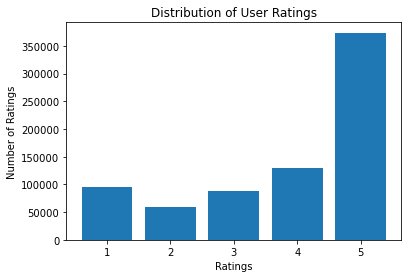

In [83]:
rating = pd.Series(data["rating"].value_counts()).sort_index()

plt.bar(rating.index, rating.values)
plt.xlabel("Ratings")
plt.ylabel("Number of Ratings")
plt.title("Distribution of User Ratings")

## Feature Importance

## Data Visualizations


### Trend of Keywords

In [84]:
data_visual = data.copy()
data_visual.index = pd.to_datetime(data_visual.reviewTime)
data_visual = data_visual[["tagged_filtered","tokenized_filtered", "bigram", "rating", "vote", "sentiment"]]
data_visual = data_visual[data_visual.index>="2013"] # To ensure the trend validity, only the years with reviews>10k are considered.
data_visual.head(5)

,tagged_filtered,tokenized_filtered,bigram,rating,vote,sentiment
reviewTime,,,,,,
2014-09-28,"[review, opening, small, hook, expensive, earrings, trying, get, higher, end, theyre, seen, buy, price, sending]","[review, open, small, hook, expensive, earrings, try, get, high, end, theyre, see, buy, price, send]","[agree review, review opening, opening small, small almost, almost bent, bent hook, hook expensive, expensive earring, earring trying, trying get, get higher, higher end, end theyre, theyre not, n...",2.0,3.0,negative
2014-08-25,"[love, going, order, pack, keep, work, someone, including, losing, earring, dont, fish, hook, earrings, dont, tiny, bit]","[love, go, order, pack, keep, work, someone, include, lose, earring, dont, fish, hook, earrings, dont, tiny, bite]","[love going, going order, order another, another pack, pack keep, keep work, work someone, someone including, including always, always losing, losing back, back earring, earring dont, dont underst...",4.0,0.0,positive
2014-05-31,"[little, plastic, backs, work, great, hook, earrings, ordered, lost, favorite, earrings]","[little, plastic, back, work, great, hook, earrings, order, lose, favorite, earrings]","[little plastic, plastic back, back work, work great, great loosing, loosing hook, hook earring, earring wish, wish ordered, ordered sooner, sooner lost, lost favorite, favorite earring, little pl...",4.0,0.0,positive
2013-09-22,"[mother, law, wanted, sister, liked, said, work]","[mother, law, want, sister, like, say, work]","[mother law, law wanted, wanted present, present sister, sister liked, liked said, said would, would work, mother law wanted, law wanted present, wanted present sister, present sister liked, siste...",3.0,0.0,neutral
2013-07-17,"[item, good, quality, looks, great, fit, fit, carefully, bottom, case, fingers, shove, pack, smax, level, case, stretching, case, closed, month, buxton, usually, good, quality, product]","[item, good, quality, look, great, fit, fit, carefully, bottom, case, finger, shove, pack, smax, level, case, stretch, case, close, month, buxton, usually, good, quality, product]","[item good, good quality, quality look, look great, great not, not fit, fit stretched, stretched fit, fit carefully, carefully push, push bottom, bottom case, case finger, finger shove, shove pack...",3.0,0.0,neutral
2013-04-13,"[used, last, fake, leather, cigarette, case, years, closed, completely, made, look, falling, time, new, cigarette, cases, kings, size, cigs, easy, days, discovered, thrilled, find, amazon, great, ...","[use, last, fake, leather, cigarette, case, years, close, completely, make, look, fall, time, new, cigarette, case, kings, size, cigs, easy, days, discover, thrill, find, amazon, great, price, rea...","[used last, last elcheapo, elcheapo fake, fake leather, leather cigarette, cigarette case, case seven, seven year, year still, still closed, closed completely, completely plastic, plastic made, ma...",3.0,0.0,neutral
2013-03-09,"[brand, long, time, count, good, quality, merchandise, held, rips, stitching, problems]","[brand, long, time, count, good, quality, merchandise, hold, rip, stitch, problems]","[brand around, around long, long time, time count, count good, good quality, quality merchandise, merchandise held, held well, well rip, rip stitching, stitching problem, brand around long, around...",4.0,0.0,positive
2013-01-27,"[smoke, made, get, cigarettes, wont, disappointed]","[smoke, make, get, cigarettes, wont, disappoint]","[smoke not, not made, made get, get cigarette, cigarette wont, wont close, close disappointed, smoke not made, not made get, made get cigarette, get cigarette wont, cigarette wont close, wont clos...",2.0,0.0,negative
2013-01-04,"[cheap, cheesy, guess, expected, price, purchase, seeing, first]","[cheap, cheesy, guess, expect, price, purchase, see, first]","[cheap cheesy, cheesy guess, guess could, could expected, expected price, price wont, wont purchase, purchase another, another without, without seeing,

In [87]:
def most_common_word_func_tokenized(token_list, n_words=15):
    # Transform review tokens into word frequency distribution dataframe

    fdist = FreqDist(token_list) 
    
    # Synoym topics are counted together
    for keyword in synonym_dic:
        if keyword in fdist:
            fdist[synonym_dic[keyword]] += fdist[keyword]
            del fdist[keyword]
    
    # filter out the target topics which are most prevalant between 2013 and 2018
    fdist_filtered = {}
    for key, value in fdist.items():
        if key in target_keyword_list:
            fdist_filtered[key] = value
    
    n_words = n_words
    
    df_fdist = pd.DataFrame({'Word': fdist_filtered.keys(),
                             'Frequency': fdist_filtered.values()})
    df_fdist = df_fdist.sort_values(by='Frequency', ascending=False).head(n_words)
    
    return df_fdist

def word_dist(df_tmp):
    token_list = df_tmp.iloc[:,0].values
    return most_common_word_func_tokenized(itertools.chain.from_iterable(token_list))

# This is a manually constructed dictionary that matched all similar topics to the same keyword
synonym_dic = {"work great":"great quality", "work perfectly": "great quality", "great product": "great quality", 
                                       "would recommend": "great quality", "work good": "great quality",
                                       "highly recommend": "great quality", "work fine": "great quality", "would recommend": "great quality",
                                       "work well": "great quality", "exactly need": "great quality", "good quality": "great quality",
                                       "good product": "great quality", "great product": "great quality", "great quality":  "great quality",
                                       "love them": "great quality", "look great": "great quality", "well make": "great quality",
                                       "look good": "great quality", "really like": "great quality", "super cute": "great quality", "like picture": "great quality",
                            "fit perfect": "fit perfectly", "perfect fit": "fit perfectly", "fit well": "fit perfectly", "fit great": "fit perfectly", "fit expect": "fit perfectly",
                            "good price": "great price"}

# After the investigations in the code blocks below, these four topics are the most prevalant and popular topics across 2013-2018.
target_keyword_list = ["great quality", "fit perfectly", "great price", "fast ship"]

data_visual["unique_bigram"] = np.array([np.unique(np.array(token)) for token in data_visual["bigram"]])
data_freq_list = data_visual[["bigram"]].groupby(data_visual.index.strftime("%Y")).apply(word_dist)
data_freq_list # DataFrame: Year - keyword - number of reviews containing this keyword

/var/folders/51/42w_kz156q920kx3w9jz1lwm0000gn/T/ipykernel_16745/3299130133.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_visual["unique_bigram"] = np.array([np.unique(np.array(token)) for token in data_visual["bigram"]])


Word  Frequency
reviewTime                            
2013       3  great quality       2175
           1  fit perfectly       2044
           0    great price        548
           2      fast ship          2
2014       0  fit perfectly       6865
           3  great quality       5692
           1    great price       1293
           2      fast ship         10
2015       1  fit perfectly      13686
           3  great quality      11447
           0    great price       2561
           2      fast ship         17
2016       0  fit perfectly      23430
           3  great quality      19138
           1    great price       3717
           2      fast ship         31
2017       0  fit perfectly      12168
           3  great quality       8535
           1    great price       2030
           2      fast ship         15
2018       1  fit perfectly       4104
           3  great quality       2752
           0    great price        689
           2      fast ship          7

In [88]:
data_count_review = data_visual[["bigram"]].groupby(data_visual.index.strftime("%Y")).apply("count") # Year - # of reviews this year

data_freq_list_all = pd.merge(data_freq_list, data_count_review, left_index=True, right_index=True, how="inner")
data_freq_list_all["keyword_prop"] = data_freq_list_all["Frequency"] / data_freq_list_all["bigram"] # % of reviews containing this keyword
data_freq_list_all.rename(columns={"bigram":"num of reviews"}, inplace=True)
data_freq_list_all.index = [index[0] for index in data_freq_list_all.index]
data_freq_list_all

,Word,Frequency,num of reviews,keyword_prop
2013,great quality,2175,26770,0.081248
2013,fit perfectly,2044,26770,0.076354
2013,great price,548,26770,0.020471
2013,fast ship,2,26770,0.000075
2014,fit perfectly,6865,79452,0.086404
2014,great quality,5692,79452,0.071641
2014,great price,1293,79452,0.016274
2014,fast ship,10,79452,0.000126
2015,fit perfectly,13686,165550,0.082670
2015,great quality,11447,165550,0.069145


In [89]:
# Reorder the dataframe by the # of reviews containing this keyword. We only want to focus on prevalant topics.
word_year_count = data_freq_list_all[["Word","keyword_prop", "Frequency"]].groupby("Word").agg(["count", "mean"])
word_year_count.sort_values(by=("keyword_prop", "count"), ascending=False)

keyword_prop           Frequency              
                     count      mean     count          mean
Word                                                        
fast ship                6  0.000112         6     13.666667
fit perfectly            6  0.083937         6  10382.833333
great price              6  0.015775         6   1806.333333
great quality            6  0.068469         6   8289.833333

In [90]:
# Create a new dataframe for visualization: entries are % of reviews in this year containing this keyword
data_freq_list_transformed = pd.DataFrame()
data_freq_list_transformed["great quality"] = data_freq_list_all[data_freq_list_all.Word == "great quality"]["keyword_prop"]
data_freq_list_transformed["fit perfectly"] = data_freq_list_all[data_freq_list_all.Word == "fit perfectly"]["keyword_prop"]
data_freq_list_transformed["great price"] = data_freq_list_all[data_freq_list_all.Word == "great price"]["keyword_prop"]
data_freq_list_transformed["fast ship"] = data_freq_list_all[data_freq_list_all.Word == "fast ship"]["keyword_prop"]
#data_freq_list_transformed["easy install"] = data_freq_list_all[data_freq_list_all.Word == "easy install"]["keyword_prop"]
data_freq_list_transformed

,great quality,fit perfectly,great price,fast ship
2013,0.081248,0.076354,0.020471,0.000075
2014,0.071641,0.086404,0.016274,0.000126
2015,0.069145,0.082670,0.015470,0.000103
2016,0.072834,0.089168,0.014146,0.000118
2017,0.059235,0.084448,0.014089,0.000104
2018,0.056714,0.084577,0.014199,0.000144


<AxesSubplot:title={'center':'Topic Trend from 2013 to 2018'}>

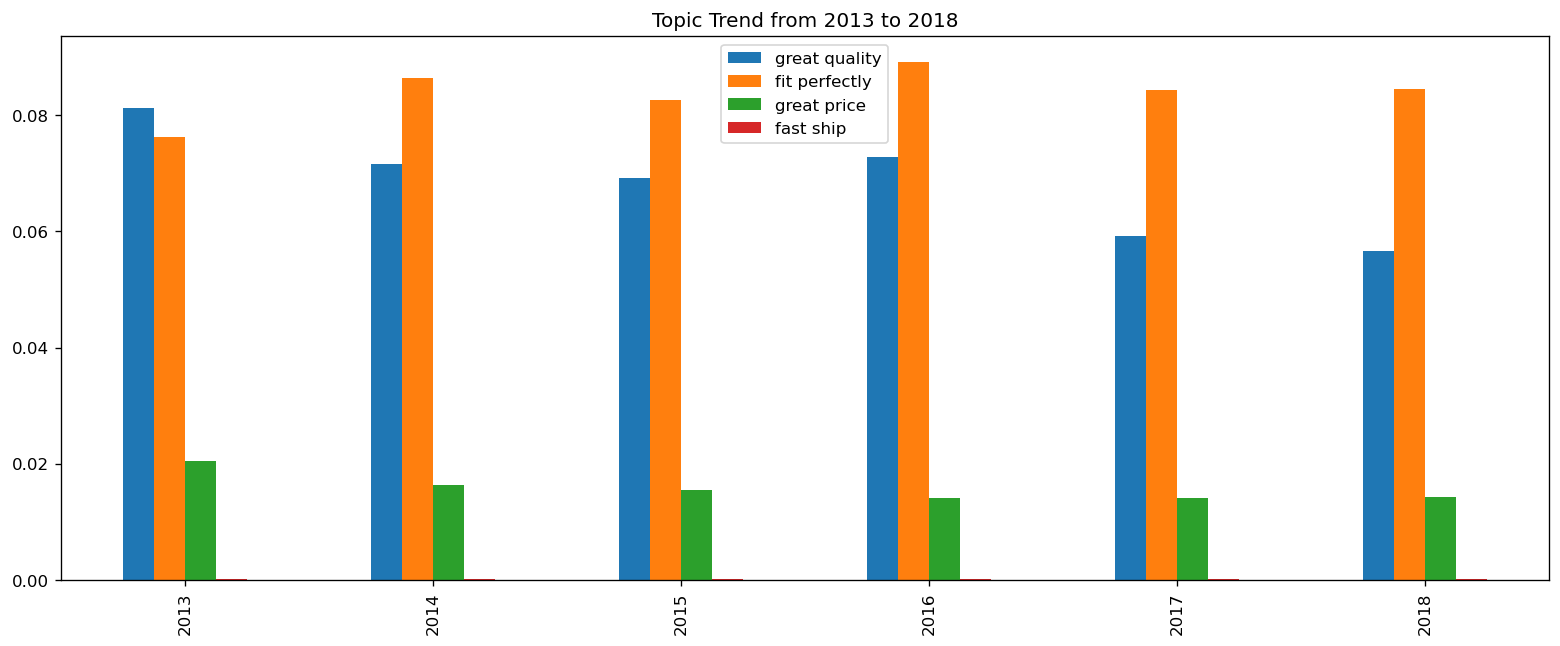

In [91]:
# Trend visualization
plt.rcParams["figure.dpi"] = 120
data_freq_list_transformed.plot(kind="bar", figsize=(16, 6), title="Topic Trend from 2013 to 2018")

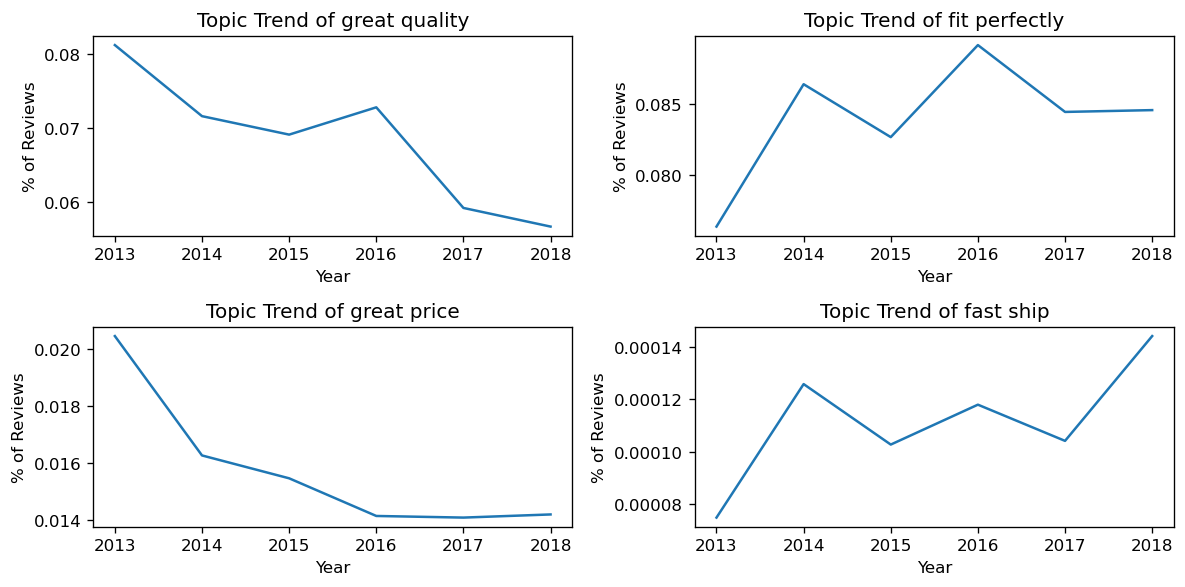

In [92]:
# Trend visualization
f, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,5), tight_layout=True, dpi=120)
for index in range(len(data_freq_list_transformed.columns)):
    axes[index//2][index%2].plot(data_freq_list_transformed.index, data_freq_list_transformed.iloc[:, index])
    axes[index//2][index%2].set(xlabel="Year", ylabel="% of Reviews", 
                                                       title = "Topic Trend of "+data_freq_list_transformed.columns[index])

### Trend of Customer Satisfaction

In [93]:
# Visualization of the trend of % of positive/neutral/negative reviews across time

data_satisfaction = data_visual[["sentiment", "bigram"]].groupby([data_visual.index.strftime("%Y"), "sentiment"]).count()
data_satisfaction

bigram
reviewTime sentiment        
2013       negative     4502
           neutral      2977
           positive    19291
2014       negative    16124
           neutral     10093
           positive    53235
2015       negative    36554
           neutral     20407
           positive   108589
2016       negative    56715
           neutral     31192
           positive   174856
2017       negative    28695
           neutral     16249
           positive    99144
2018       negative     9097
           neutral      5151
           positive    34276

In [94]:
data_sat_all = pd.merge(data_satisfaction, data_count_review, left_index=True, right_index=True, how="inner")
data_sat_all["% of reviews"] = data_sat_all["bigram_x"] / data_sat_all["bigram_y"] # % of reviews containing this keyword
data_sat_all.rename(columns={"bigram_x":"num of reviews", "bigram_y":"total reviews"}, inplace=True)
data_sat_all.reset_index(inplace=True)
data_sat_all.index = data_sat_all["reviewTime"]
data_sat_all.drop(columns="reviewTime", inplace=True)
data_sat_all

,sentiment,num of reviews,total reviews,% of reviews
reviewTime,,,,
2013,negative,4502,26770,0.168173
2013,neutral,2977,26770,0.111207
2013,positive,19291,26770,0.720620
2014,negative,16124,79452,0.202940
2014,neutral,10093,79452,0.127033
2014,positive,53235,79452,0.670027
2015,negative,36554,165550,0.220803
2015,neutral,20407,165550,0.123268
2015,positive,108589,165550,0.655929


In [95]:
# Create a new dataframe for visualization: entries are % of reviews in this year containing this keyword
data_sat_all_transformed = pd.DataFrame()
data_sat_all_transformed["positive"] = data_sat_all[data_sat_all.sentiment == "positive"]["% of reviews"]
data_sat_all_transformed["neutral"] = data_sat_all[data_sat_all.sentiment == "neutral"]["% of reviews"]
data_sat_all_transformed["negative"] = data_sat_all[data_sat_all.sentiment == "negative"]["% of reviews"]
data_sat_all_transformed

,positive,neutral,negative
reviewTime,,,
2013,0.720620,0.111207,0.168173
2014,0.670027,0.127033,0.202940
2015,0.655929,0.123268,0.220803
2016,0.665451,0.118708,0.215841
2017,0.688080,0.112771,0.199149
2018,0.706372,0.106154,0.187474


<AxesSubplot:title={'center':'Trend of Customer Satisfaction from 2013 to 2018'}, xlabel='reviewTime'>

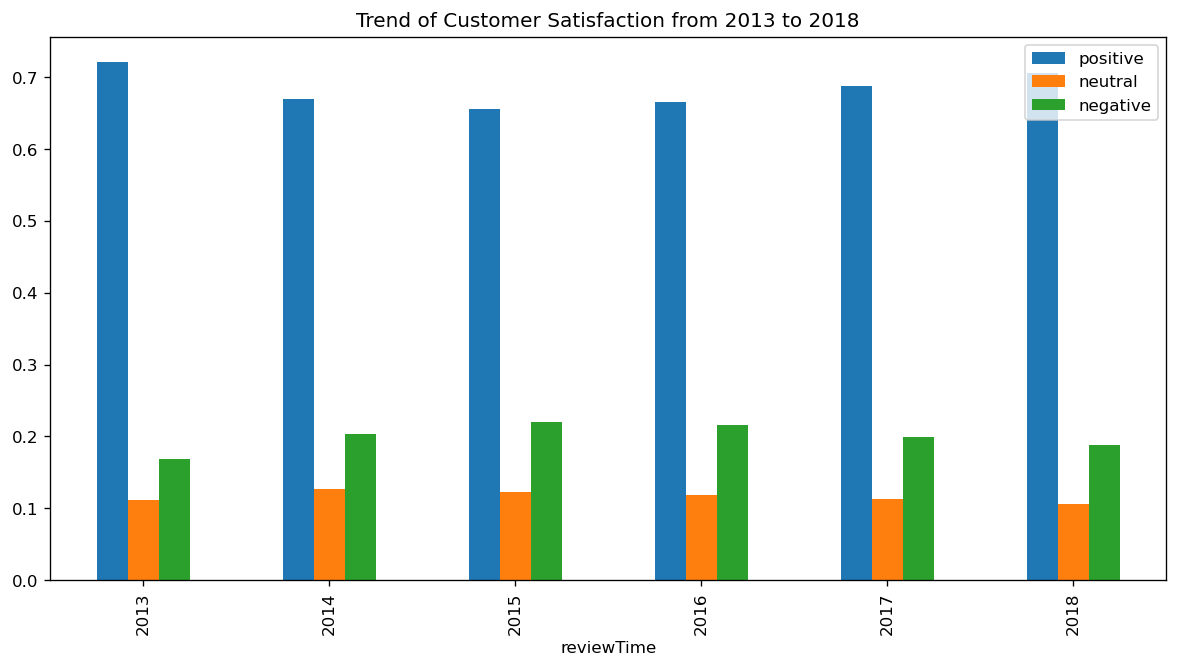

In [96]:
plt.rcParams["figure.dpi"] = 120
data_sat_all_transformed.plot(kind="bar", figsize=(12, 6), title="Trend of Customer Satisfaction from 2013 to 2018")